# Churn Prediction in the Credit Card Industry
![Churn Prediction](Images/Churn.jpg)
## Objective:
<p align="justify">
Early detection of customers at risk of churning the credit card service. Extreme Gradient Boosting is the algorithm of choice due to the imbalanced nature of the data set (which is handled through SMOTE). Results include evaluation metrics, confusion matrix, R.O.C. curve and the extraction of the features influencing online purchases the most. The analysis offers both technical and practical implications of predictive analytics in business while also suggesting areas for further improvement and development.
</p>


[Churns.csv](https://github.com/justgrossi/Portfolio/blob/main/2.Churn_Prediction/churns.csv)

<p align="justify">
A consumer credit card bank faced the problem of customer attrition and wanted to analyze the data to find out the reason(s) behind the issue and leverage this new knowledge to predict customers who are most likely to drop off. The data set includes 6 categorical and 14 numerical features for a total of 10,127 observations. The target label is "churned" characterizing 16.06% of the samples. The remaining features are:
    
1. Socio-demographic factors such as "*age*", "*gender*", "*education level*", "*marital status*", "*credit card*" and "*income category*".
2. Variables characterizing both customers' credit card usage and their relationship with the bank such as for instance "*duration of the relationship*", "*number of products held*" by the customer, "*total number of inactivity over the last 12 months*", "*number of contacts during the last 12 months*", "*revolving balance*", "*change in transactions amount and volume*", and "*average credit card utilization ratio*".  
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, label_binarize
from collections import Counter
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

In [24]:
# Data exploration
def load_and_inspect_data(file_path):
    """Load the dataset and perform initial inspection"""
    print("=" * 60)
    print("LOADING AND INSPECTING DATA")
    print("=" * 60)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumn names and types:")
    print(df.dtypes)
    
    print(f"\nMissing values per column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])

    print(f"\nDuplicated values:")
    print(df.duplicated().sum())
    display(df.head())
    return df


# Function to plot conditioned histograms
def cond_hists(df, plot_cols, grid_col):
    import matplotlib.pyplot as plt
    import seaborn as sns
    ## Loop over the list of columns
    for col in plot_cols:
        grid1 = sns.FacetGrid(df, col=grid_col)
        grid1.map(plt.hist, col, alpha=.7)
    return grid_col


# Check strings values
def check_string_values(cols):
    for col in cols:
        print(f'VARIABLE:')
        print(df[col].value_counts())
        print('================')


# Get Feature importances -- best 10
def feature_importance_list(best_model):
    # Get final estimator -- the actual model
    final_estimator = best_model.named_steps["classifier"]

    if hasattr(final_estimator, "feature_importances_"):
        importances = final_estimator.feature_importances_

        # Get feature names after preprocessing
        preprocessor = best_model.named_steps["preprocessor"]
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            feature_names = X_train.columns  # fallback

        # Build DataFrame
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Importance": importances})
            .sort_values("Importance", ascending=False)
        ).head(10)

        print("\nFeature Importances:")
        print(importance_df)

    elif hasattr(final_estimator, "coef_"):
        importances = (
            final_estimator.coef_[0]
            if len(final_estimator.coef_.shape) > 1
            else final_estimator.coef_
        )

        preprocessor = best_model.named_steps["preprocessor"]
        try:
            feature_names = preprocessor.get_feature_names_out()
        except:
            feature_names = X_train.columns  # fallback
    
        importance_df = (
            pd.DataFrame({"Feature": feature_names, "Coefficient": importances})
            .sort_values("Coefficient", ascending=False)
        ).head(10)
    
        print("\nModel Coefficients:")
        print(importance_df)

    else:
        print("This model does not provide feature importances or coefficients.")


# Plot Feature importances
def plot_feature_importance(best_model):
    plt.style.use('ggplot')

    final_estimator = best_model.named_steps["classifier"]
    importances = final_estimator.feature_importances_
    plt.hist(importances, bins=20)
    
    plt.title("Distribution of Feature Importances")
    plt.xlabel("Feature Importance")
    plt.ylabel("Number of Features")
    plt.tight_layout()
    plt.show()


# Plot ROC curve
def roc_curve_plot(best_model, X_test, y_test_enc, class_names=None):
    """
    Plot ROC curve for binary or multiclass classification.
    - best_model: trained model with predict_proba
    - X_test: test features
    - y_test_enc: encoded numeric labels (0,1,...)
    - class_names: optional original class names
    """
    if hasattr(best_model, "predict_proba"):
        y_proba = best_model.predict_proba(X_test)
        classes = np.unique(y_test_enc)

        if len(classes) == 2:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_test_enc, y_proba[:, 1])
            roc_auc = auc(fpr, tpr)

            plt.figure(figsize=(6, 6))
            plt.plot(fpr, tpr, color="darkorange", lw=2,
                     label=f"ROC curve (AUC = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Receiver Operating Characteristic (ROC)")
            plt.legend(loc="lower right")
            plt.show()

        else:
            # Multi-class classification (one-vs-rest)
            y_test_bin = label_binarize(y_test_enc, classes=classes)

            plt.figure(figsize=(8, 6))
            for i, c in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
                roc_auc = auc(fpr, tpr)
                label = f"Class {class_names[i]}" if class_names is not None else f"Class {c}"
                plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Multi-class ROC Curve")
            plt.legend(loc="lower right")
            plt.show()

    else:
        print("This model does not support predict_proba, ROC curve not available.")



# Save best model for later use
def save_best_model(best_model, X_test, y_test, le):
    import joblib
    from sklearn.metrics import accuracy_score

    joblib.dump(best_model, "best_model.pkl")
    print("✅ Model saved as best_model.pkl")

    # Load the model
    loaded_model = joblib.load("best_model.pkl")
    print("✅ Model reloaded successfully")

    # Confirm reloaded model works
    y_pred_loaded = loaded_model.predict(X_test)
    y_pred_decoded = le.inverse_transform(y_pred_loaded)  # back to 'yes'/'no'
    print("Reloaded model Accuracy:", accuracy_score(y_test, y_pred_decoded))

In [3]:
file_path='churns.csv'
df=load_and_inspect_data(file_path)

LOADING AND INSPECTING DATA
Dataset shape: (10127, 20)

Column names and types:
churned                         object
age                              int64
gender                          object
number_of_dependents             int64
education_level                 object
marital                         object
income_category                 object
card_category                   object
months_on_book                   int64
tot_prods_held                   int64
mon_inactive                     int64
num_contacts                     int64
cred_lim                       float64
revolving_bal                    int64
avg_willing_to_buy             float64
delta12_amount_transactions    float64
tot_amount_transactions          int64
tot_count_transactions           int64
delta12_count_transactions     float64
ratio                          float64
dtype: object

Missing values per column:
Series([], dtype: int64)

Duplicated values:
0


,churned,age,gender,number_of_dependents,education_level,marital,income_category,card_category,months_on_book,tot_prods_held,mon_inactive,num_contacts,cred_lim,revolving_bal,avg_willing_to_buy,delta12_amount_transactions,tot_amount_transactions,tot_count_transactions,delta12_count_transactions,ratio
0,no,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,no,49,F,5,Graduate,Single,Less than $40K,blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,no,51,M,3,Graduate,Married,$80K - $120K,blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,no,40,F,4,High School,999,Less than $40K,blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,no,40,M,3,Uneducated,Married,$60K - $80K,blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df.columns=df.columns.str.strip()

In [5]:
df.rename(columns={
    'number_of_dependents': 'num_dep',
    'education_level': 'edu_level',
    'income_category': 'income_cat',
    'card_category': 'card_cat',
    'months_on_book': 'longevity'    
}, inplace=True)

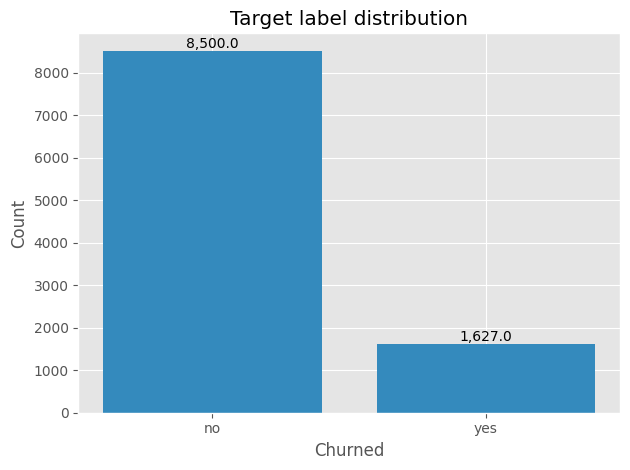

In [6]:
plt.style.use('ggplot')

x_churned=df['churned'].value_counts().index
y_churned=df['churned'].value_counts().values

plt.bar(x_churned, y_churned)
bars = plt.bar(x_churned, y_churned)
plt.bar_label(bars, fmt='{:,}')
plt.title('Target label distribution')
plt.xlabel('Churned')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [7]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns

# Select only string/object columns
string_cols = df.select_dtypes(include=['object']).columns

'churned'

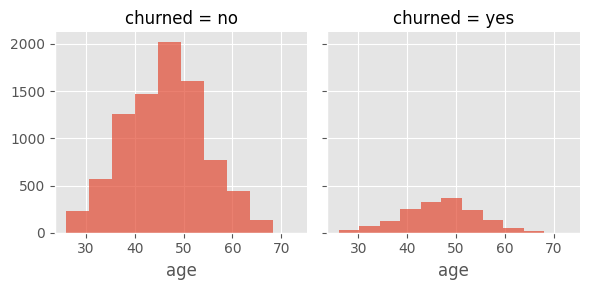

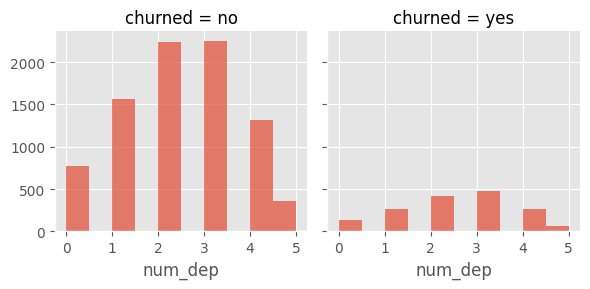

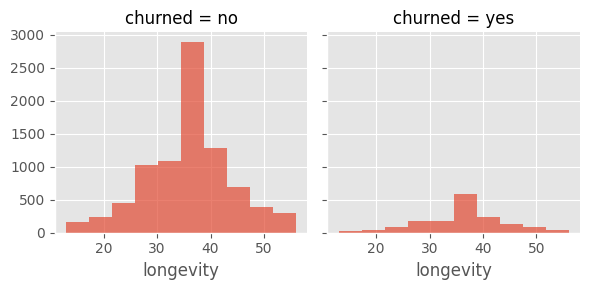

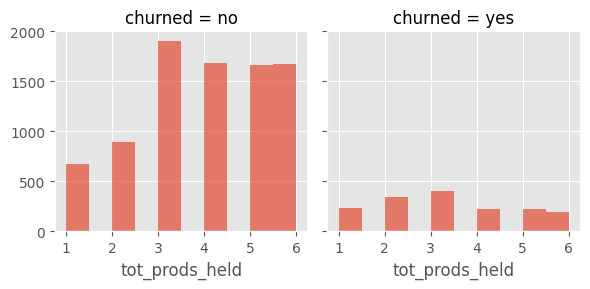

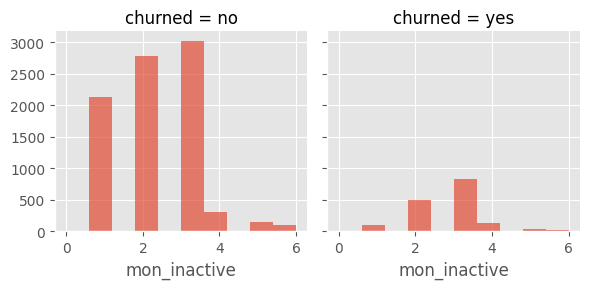

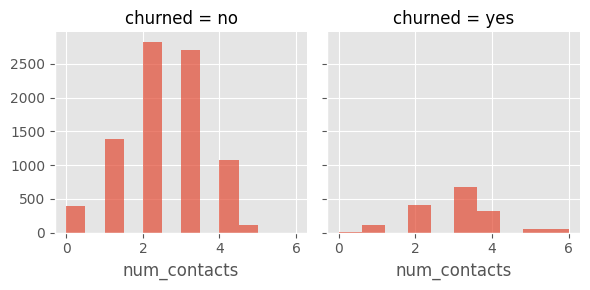

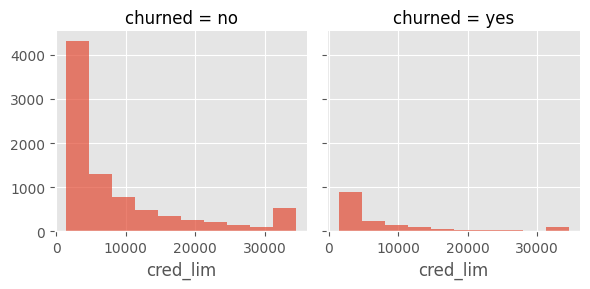

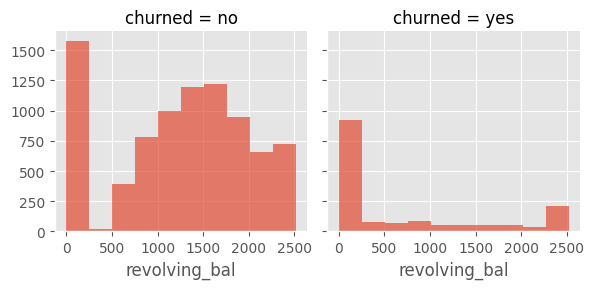

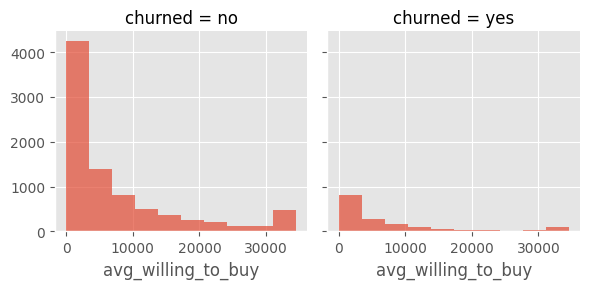

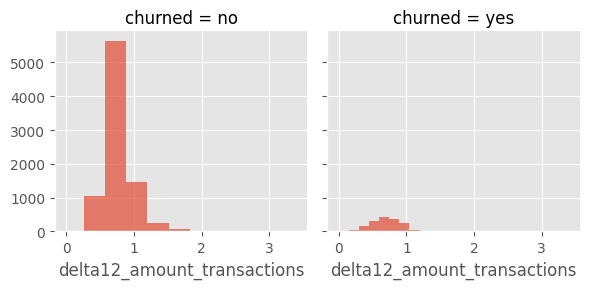

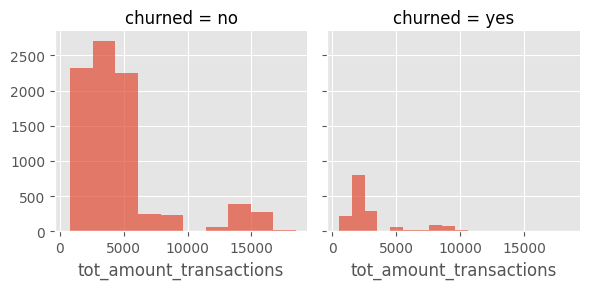

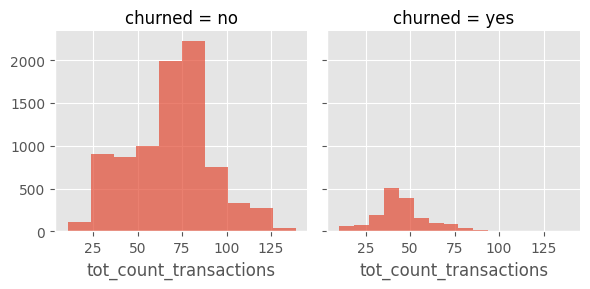

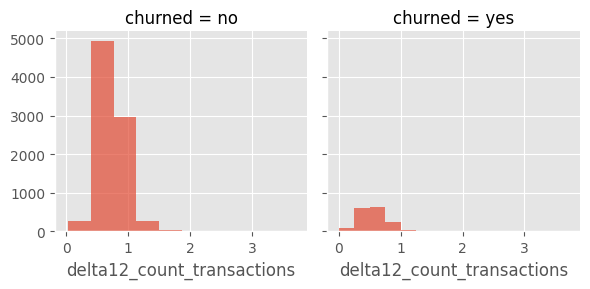

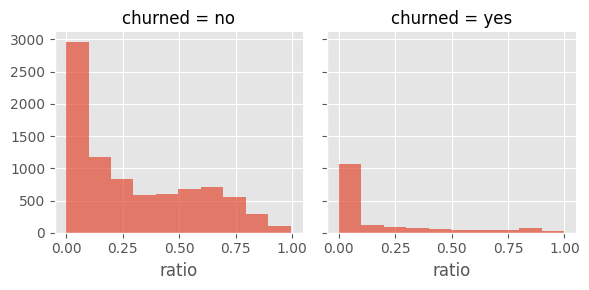

In [8]:
# Explore numerical columns vs target label
# EDA highlights key differences between the two cohorts
cond_hists(df, numeric_cols, 'churned')

In [9]:
check_string_values(string_cols)

VARIABLE:
churned
no     8500
yes    1627
Name: count, dtype: int64
VARIABLE:
gender
F    5358
M    4769
Name: count, dtype: int64
VARIABLE:
edu_level
Graduate         3099
High School      2013
Unknown          1496
Uneducated       1487
College          1013
Post-Graduate     497
Doctorate         436
Grad               29
Nil                23
Post-Grad          19
Doc                15
Name: count, dtype: int64
VARIABLE:
marital
Married     4687
Single      3943
Divorced     730
Unknown      692
Nil           29
999           28
Div           18
Name: count, dtype: int64
VARIABLE:
income_cat
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64
VARIABLE:
card_cat
Blue        9387
Silver       497
Gold          79
silver        37
B             34
G             27
s             21
blue          15
Platinum      11
gold          10
P              6
platinum       3
Name: coun

In [10]:
# Set mappers to fix values
mapper_edu_level={ 
    'Graduate' : 'Graduate',       
    'High School' : 'High School',    
    'Unknown' : 'Unknown',        
    'Uneducated' : 'Uneducated',     
    'College' : 'College',        
    'Post-Graduate' : 'Post-Graduate',   
    'Doctorate' : 'Doctorate',       
    'Grad' : 'Graduate',             
    'Nil' : 'Unknown',              
    'Post-Grad' : 'Post-Graduate',
    'Doc' : 'Doctorate' 
}

mapper_marital={
    'Married' : 'Married',    
    'Single' : 'Single',     
    'Divorced' : 'Divorced',    
    'Unknown' : 'Unknown',    
    'Nil' : 'Unknown',          
    '999' : 'Unknown',          
    'Div' : 'Divorced'
}

mapper_card_cat={
    'Blue':'Blue',
    'blue':'Blue',
    'Silver' : 'Silver',
    'Gold':'Gold',
    'gold':'Gold',
    'silver' : 'Silver',
    'Platinum' : 'Platinum',
     'platinum' : 'Platinum',
    'B':'Blue',
    'G':'Gold',
    'P':'Platinum',
    's':'Silver'
}

In [11]:
df['edu_level']=df['edu_level'].map(mapper_edu_level)
df['marital']=df['marital'].map(mapper_marital)
df['card_cat']=df['card_cat'].map(mapper_card_cat)

In [12]:
check_string_values(string_cols)

VARIABLE:
churned
no     8500
yes    1627
Name: count, dtype: int64
VARIABLE:
gender
F    5358
M    4769
Name: count, dtype: int64
VARIABLE:
edu_level
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: count, dtype: int64
VARIABLE:
marital
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: count, dtype: int64
VARIABLE:
income_cat
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: count, dtype: int64
VARIABLE:
card_cat
Blue        9436
Silver       555
Gold         116
Platinum      20
Name: count, dtype: int64


In [13]:
df.isna().sum()

churned                        0
age                            0
gender                         0
num_dep                        0
edu_level                      0
marital                        0
income_cat                     0
card_cat                       0
longevity                      0
tot_prods_held                 0
mon_inactive                   0
num_contacts                   0
cred_lim                       0
revolving_bal                  0
avg_willing_to_buy             0
delta12_amount_transactions    0
tot_amount_transactions        0
tot_count_transactions         0
delta12_count_transactions     0
ratio                          0
dtype: int64

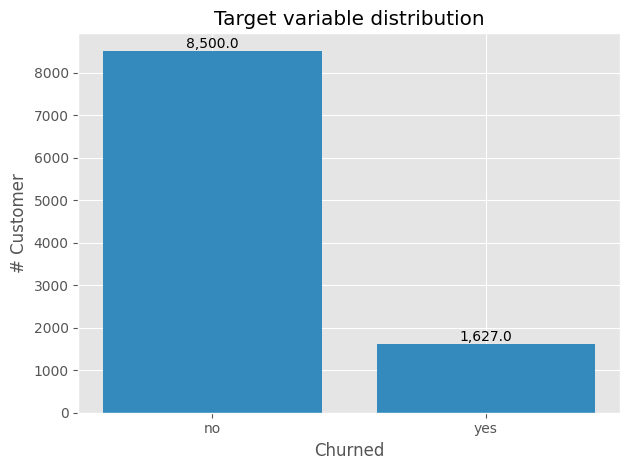

In [14]:
# Label distribution
plt.style.use('ggplot')

x=df['churned'].value_counts().index
y=df['churned'].value_counts().values

plt.bar(x, y)
bars = plt.bar(x, y)
plt.bar_label(bars, fmt='{:,}')
plt.title('Target variable distribution')
plt.xticks([0, 1])
plt.xlabel('Churned')
plt.ylabel('# Customer')

plt.tight_layout()
plt.show()

In [15]:
# Split into train test

X=df.drop("churned", axis=1)
y=df['churned']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
# Define preprocessing for numeric and categorical columns
num_cols=X.select_dtypes(include=['number']).columns
str_cols= X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
# Combine them with ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, str_cols)
])

# Create final pipeline + SMOTE
clf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", XGBClassifier())
])

In [17]:
param_grid= {
            "classifier__n_estimators": [200, 300, 500],
            "classifier__max_depth": [3, 5, 7],
            "classifier__learning_rate": [0.01, 0.1, 0.2]
        }

In [18]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=clf_pipeline,
param_distributions=param_grid,
n_iter=20,
cv=5,
n_jobs=-1,
verbose=0,
random_state=42)

In [19]:
# Train & Evaluate
# Encode label into 1/0
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Now fit with encoded labels
random_search.fit(X_train, y_train_enc)


# Best model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_


# Predictions
y_pred = best_model.predict(X_test)

# Back to 'yes'/'no'
y_pred_labels = le.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test, y_pred_labels))
print("F1 Score:", f1_score(y_test, y_pred_labels, average="weighted"))
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}
Accuracy: 0.9718657453109576
F1 Score: 0.9714823969851448
Classification Report:
               precision    recall  f1-score   support

          no       0.98      0.99      0.98      1701
         yes       0.94      0.88      0.91       325

    accuracy                           0.97      2026
   macro avg       0.96      0.93      0.95      2026
weighted avg       0.97      0.97      0.97      2026



In [20]:
# 10 Most important features
feature_importance_list(best_model)


Feature Importances:
                            Feature  Importance
11      num__tot_count_transactions    0.216094
7                num__revolving_bal    0.106507
3               num__tot_prods_held    0.069367
4                 num__mon_inactive    0.054855
5                 num__num_contacts    0.045047
15                    cat__gender_M    0.043892
12  num__delta12_count_transactions    0.041436
24             cat__marital_Married    0.040748
18          cat__edu_level_Graduate    0.040024
10     num__tot_amount_transactions    0.037351


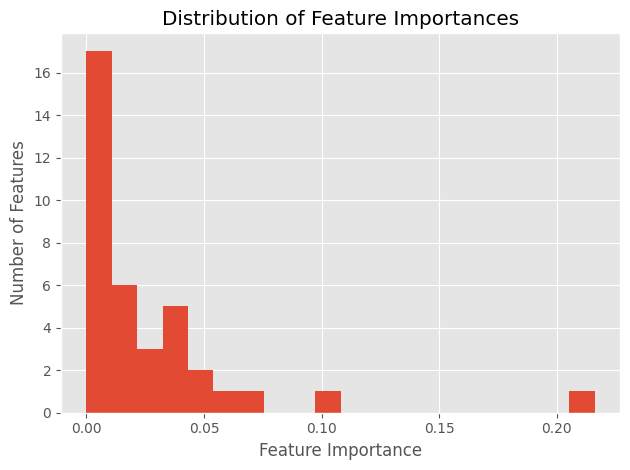

In [21]:
# Feature importances
plot_feature_importance(best_model)

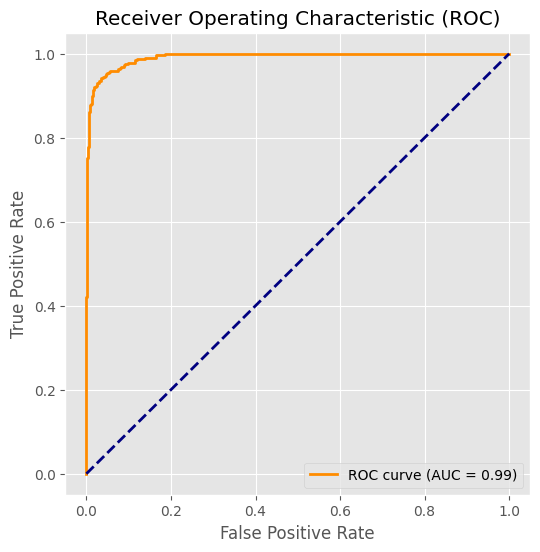

In [22]:
# ROC curve
roc_curve_plot(best_model, X_test, y_test_enc, class_names=le.classes_)

In [25]:
# Save the model
# save_best_model(best_model, X_test, y_test, le)

✅ Model saved as best_model.pkl
✅ Model reloaded successfully
Reloaded model Accuracy: 0.9718657453109576
